<a href="https://colab.research.google.com/github/quicksilverri/fanfic-popularuty-prediction/blob/main/fanfic_popularity_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import staff

In [68]:
import requests as req
from bs4 import BeautifulSoup
import pandas as pd 
import seaborn as sns
from time import time
import matplotlib.pyplot as plt

%matplotlib inline

# Get the data

In [2]:
marvel_link =  'https://archiveofourown.org/works?commit=Sort+and+Filter&work_search%5Bsort_column%5D=authors_to_sort_on&work_search%5Bother_tag_names%5D=&work_search%5Bexcluded_tag_names%5D=&work_search%5Bcrossover%5D=&work_search%5Bcomplete%5D=&work_search%5Bwords_from%5D=&work_search%5Bwords_to%5D=&work_search%5Bdate_from%5D=&work_search%5Bdate_to%5D=&work_search%5Bquery%5D=&work_search%5Blanguage_id%5D=&tag_id=Marvel'
xmen_link = 'https://archiveofourown.org/works?work_search%5Bsort_column%5D=revised_at&work_search%5Bother_tag_names%5D=&exclude_work_search%5Bfreeform_ids%5D%5B%5D=11175&exclude_work_search%5Bfreeform_ids%5D%5B%5D=263297&work_search%5Bexcluded_tag_names%5D=&work_search%5Bcrossover%5D=&work_search%5Bcomplete%5D=&work_search%5Bwords_from%5D=&work_search%5Bwords_to%5D=&work_search%5Bdate_from%5D=&work_search%5Bdate_to%5D=&work_search%5Bquery%5D=&work_search%5Blanguage_id%5D=&commit=Sort+and+Filter&tag_id=Erik+Lehnsherr*s*Charles+Xavier'
link = marvel_link
pages = 1000

### Create Fanfic class

It's kinda long and simple, so it's hidden. 

In [3]:
def clean(list): 
  """Extracts text from list of bs4.Tags"""

  return [item.get_text() for item in list]

In [4]:
class Fanfic: 
  def __init__(self, fanfic):
    self.fic = fanfic
    self.info = {}

    self.header = self.fic.select('.heading a')
    
    self.get_header()
    self.get_chapters()
    self.get_stats()
    self.get_date()
    self.get_tags()
    self.get_square()

  def get_header(self):
    """Sets title, author nickname and list of fandoms into self.stats dict"""
    
    self.info['title'] = self.header[0].get_text()
    self.info['author'] = self.header[1].get_text()
    self.info['fandoms'] = clean(self.header[2:])

  def get_chapters(self): 
    """Sets number of chapters written and number of chapters intended
    into self.stats dict"""

    def smart_int(n):
      try: 
        return int(n)
      except:
        return None

    chapters = self.fic.select('dd.chapters')[0].get_text()
    written, total = map(smart_int, chapters.split('/'))

    self.info['written'] = written
    self.info['total'] = total

  def get_number(self, selector): 
     """Processes numerical data (removes comma so it can be turned
     into integer)"""

     try: 

       data = self.fic.select(selector)[0].get_text()
       data = int(data.replace(',', ''))
       return data
        
     except: return None

  def get_stats(self): 
     """Sets data collected in Stats section (words, hits, comments,
     bookmarks, collections and language) into self.info dict"""

     self.info['words'] = self.get_number('dd.words')
     self.info['hits'] = self.get_number('dd.hits') 
     self.info['comments'] = self.get_number('dd.comments') 
     self.info['bookmarks'] = self.get_number('dd.bookmarks')
     self.info['collections'] = self.get_number('dd.collections') 
     self.info['lang'] = self.fic.select('dd.language')[0].get_text()
     self.info['kudos'] = self.get_number('.kudos a')

  def get_date(self):  # add date of first publishing??
    """Sets date of the most recent update into self.dict"""

    self.info['date'] = self.fic.select('.datetime')[0].get_text() 
    
  def get_tags(self): 
    """Sets tag-like data into self.info dict"""

    self.info['characters'] = clean(self.fic.select('.characters a.tag'))
    self.info['parings'] = clean(self.fic.select('.relationships a.tag'))
    self.info['freeforms'] = clean(self.fic.select('.freeforms a.tag'))

  def get_square(self): 
    """Sets data from square to the left of fanfic title into self.info dict"""

    self.info['rating'] = self.fic.select('.rating .text')[0].get_text()
    self.info['category'] = clean(self.fic.select('.category .text'))
    self.info['completion'] = self.fic.select('.iswip .text')[0].get_text()
    self.info['warnings'] = clean(self.fic.select('.warnings a.tag'))

  def get_info(self):
     """Return all the data about Fanfic in a DataFrame"""

     df = pd.DataFrame([self.info])

     return df

### Create FanficParser

In [30]:
class FanficParser: 
  def __init__(self, initial_link):
    self.inlink = initial_link
    self.domain = self.get_domain()
    self.df = pd.DataFrame()
    self.link = self.inlink
    self.page = 1

    self.fanfics = []

  def get_domain(self):
     end_of_link = self.inlink.find('/', 8)
     domain = self.inlink[:end_of_link]
     return domain
  
  def parse_page(self): 
    page = req.get(self.link)
    soup = BeautifulSoup(page.content, 'html.parser')
    self.fanfics = soup.select('[role~=article]')

    new_link_relative = soup.select('li.next a')[0].get('href')
    self.link = self.domain + new_link_relative

    print(f'{self.page} parsed')
    self.page += 1

  def parse(self, n_pages): 
    start_time = time()
    
    for i in range(n_pages): 
      self.parse_page()
      
      for fanfic in self.fanfics:
        self.df = self.df.append(Fanfic(fanfic).get_info())

    print(f'total {self.df.shape[0]} fanfics')

    self.df.index = range(self.df.shape[0])

    end_time = time()

    print(f'time for execution {end_time - start_time}')

  def reset(self):
    self.df = pd.DataFrame()
    self.link = self.inlink
    self.page = 1
    print('Parser resetted')

## Parse info

In [32]:
parser = FanficParser(link)

In [56]:
parser.parse(300)

361 parsed
362 parsed
363 parsed
364 parsed
365 parsed
366 parsed
367 parsed
368 parsed
369 parsed
370 parsed
371 parsed
372 parsed
373 parsed
374 parsed
375 parsed
376 parsed
377 parsed
378 parsed
379 parsed
380 parsed
381 parsed
382 parsed
383 parsed
384 parsed
385 parsed
386 parsed
387 parsed
388 parsed
389 parsed
390 parsed
391 parsed
392 parsed
393 parsed
394 parsed
395 parsed
396 parsed
397 parsed
398 parsed
399 parsed
400 parsed
401 parsed
402 parsed
403 parsed
404 parsed
405 parsed
406 parsed
407 parsed
408 parsed
409 parsed
410 parsed
411 parsed
412 parsed
413 parsed
414 parsed
415 parsed
416 parsed
417 parsed
418 parsed
419 parsed
420 parsed
421 parsed
422 parsed
423 parsed
424 parsed
425 parsed
426 parsed
427 parsed
428 parsed
429 parsed
430 parsed
431 parsed
432 parsed
433 parsed
434 parsed
435 parsed
436 parsed
437 parsed
438 parsed
439 parsed
440 parsed
441 parsed
442 parsed
443 parsed
444 parsed
445 parsed
446 parsed
447 parsed
448 parsed
449 parsed
450 parsed
451 parsed

IndexError: ignored

In [57]:
df = parser.df

In [58]:
df.shape

(9600, 20)

In [59]:
df.to_csv('9600fanfics.csv')

# Data preprocessing 
So now we have to figure out what type of data can be suitable for our model. 

1. Replace missing values 
2. Parse dates 
3. Replace categorical values with numbers

In [60]:
df['comments'] = df['comments'].fillna(0)
df['bookmarks'] = df['bookmarks'].fillna(0)
df['collections'] = df['collections'].fillna(0)
df['kudos'] = df['kudos'].fillna(0)

In [61]:
ratings = {
    'Not Rated': -1,
    'General Audiences': 0, 
    'Teen And Up Audiences': 1, 
    'Mature': 2, 
    'Explicit': 3, 
}
replace_rating = lambda x: ratings[x] if x not in [-1, 0, 1, 2, 3] else x
df['rating'] = df['rating'].apply(replace_rating)

In [62]:
completion = {'Work in Progress': 0, 'Complete Work': 1}
replace_completion = lambda x: completion[x] if x not in [0, 1] else x
df['completion'] = df['completion'].apply(replace_completion)

In [63]:
df['date'] = df['date'].apply(pd.to_datetime)

# IDK staff

## Let's look at the data

In [97]:
fandom_list = set()

for fandoms in df.fandoms:
  for fandom in fandoms: 
    fandom_list.add(fandom)

In [98]:
fandom_count = {}

for fandoms in df.fandoms:
  for fandom in fandoms: 
    try: 
      fandom_count[fandom] += 1
    except: 
      fandom_count[fandom] = 1

In [99]:
count = pd.Series(fandom_count)

In [100]:
count = count.sort_values(ascending=False)

In [101]:
df_count = pd.DataFrame()
df_count['count'] = count
df_count['fandom'] = count.index

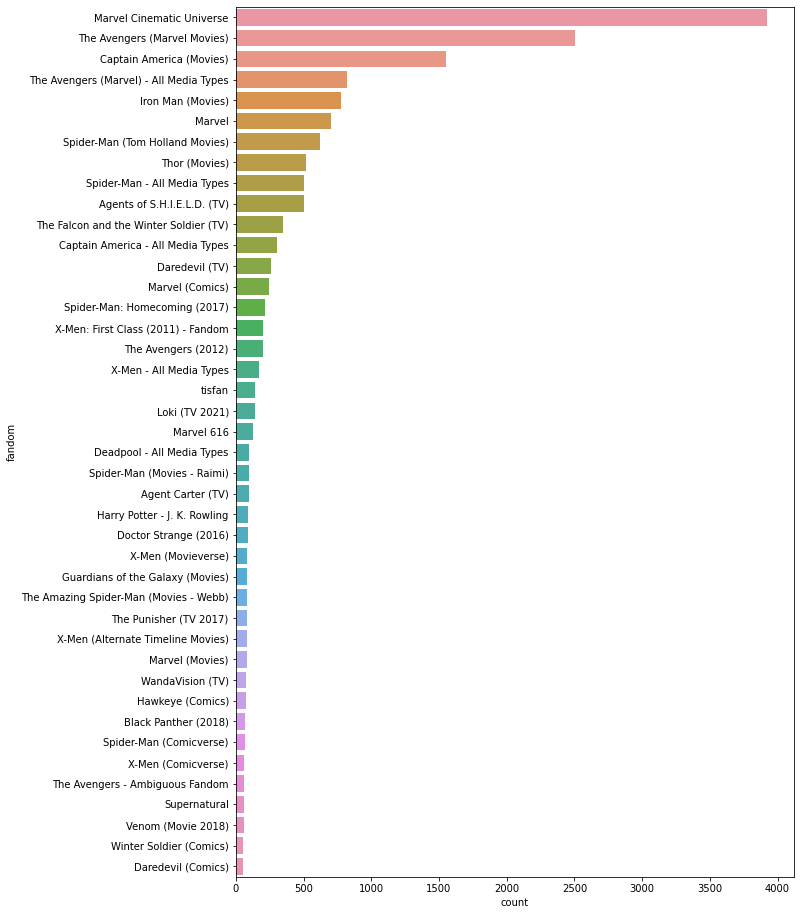

In [104]:
plt.figure(figsize=(10, 16))
sns.barplot(data=df_count[df_count['count'] > 50], x='count', y='fandom', orient='h')

## Let's look at the correlation

In [ ]:
df_num = df[['written', 'words', 'hits', 'comments', 'bookmarks', 'collections', 'rating', 'kudos', 'completion']]
df_num['words_per_chapter'] = df_num['words'] / df_num['written']
df_num['lang_num'] = df['lang'].apply(lambda x: 1 if x == 'English' else 0)
df_num['kudos_per_hit'] = df['kudos'] / df['hits']

In [65]:
df_num.describe()

,written,words,hits,comments,bookmarks,collections,rating,kudos,completion,words_per_chapter,lang_num,kudos_per_hit
count,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.0000,9600.000000,9600.000000
mean,2.882708,7113.124583,4087.290521,26.629896,32.723125,0.533229,1.020938,248.140104,0.827812,inf,0.926771,0.067909
std,7.328651,20506.176438,11367.410618,111.737413,123.508212,0.953301,1.234669,684.657556,0.377563,NaN,0.260526,0.046349
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.0000,0.000000,0.000000
25%,1.000000,998.000000,525.750000,2.000000,2.000000,0.000000,0.000000,28.000000,1.000000,843.7500,1.000000,0.035768
50%,1.000000,2180.500000,1364.000000,5.000000,6.000000,0.000000,1.000000,80.000000,1.000000,1652.9375,1.000000,0.059480
75%,2.000000,5410.000000,3515.500000,17.000000,22.000000,1.000000,2.000000,217.250000,1.000000,3148.2500,1.000000,0.091057
max,373.000000,832919.000000,456526.000000,4376.000000,6094.000000,28.000000,3.000000,24526.000000,1.000000,inf,1.000000,1.000000


In [66]:
df_corr = df_num.corr()

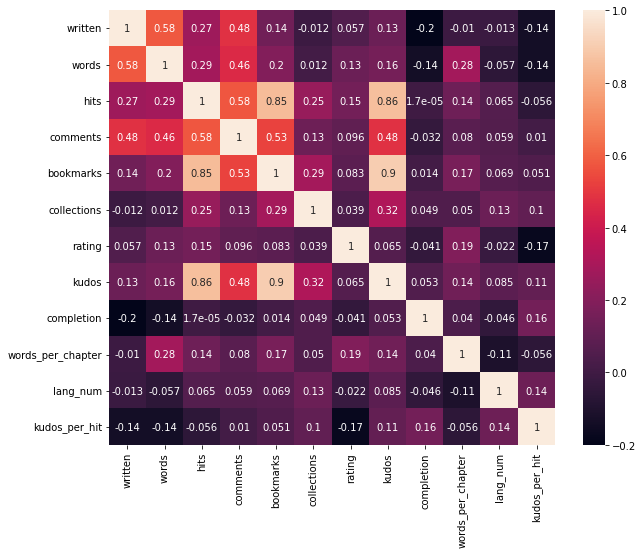

In [69]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True)

# Machine Learning yo

In [80]:
df_num = df_num[df_num.written > 0]

In [92]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [81]:
y = df_num.kudos

In [115]:
fanfic_features = ['written', 'words_per_chapter',  
                   'words', 'rating', 'completion', 'lang_num']
              
X = df_num[fanfic_features]

In [116]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [117]:
fanfic_model = DecisionTreeRegressor(random_state=1)

In [118]:
fanfic_model.fit(train_X, train_y)

DecisionTreeRegressor(random_state=1)

In [119]:
val_predictions = fanfic_model.predict(val_X)

In [110]:
val_predictions

array([177.,  38.,  34., ...,  45., 276.,   3.])

In [120]:
mean_absolute_error(val_y, val_predictions)

336.54360019449155

In [121]:
y_comparison = pd.DataFrame()
y_comparison['actual'] = val_y
y_comparison['predicted'] = val_predictions

In [122]:
y_comparison

,actual,predicted
0,254,72.0
1544,53,381.0
5989,32,374.0
0,233,125.0
307,221,115.0
...,...,...
0,99,144.0
17,135,32.0
4613,41,175.0
1993,263,224.0
